# Loading in peak files

In [2]:
import pandas as pd

peaks = pd.read_csv('./peaks/GSE39271_S2_GFPi_CLAMP_IP.consensus_peaks.bed',sep="\t",header=None)

In [3]:
peaks['peak_size'] = peaks[2] - peaks[1]

/Users/josephaguilera/opt/anaconda3/envs/ucsc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/josephaguilera/opt/anaconda3/envs/ucsc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


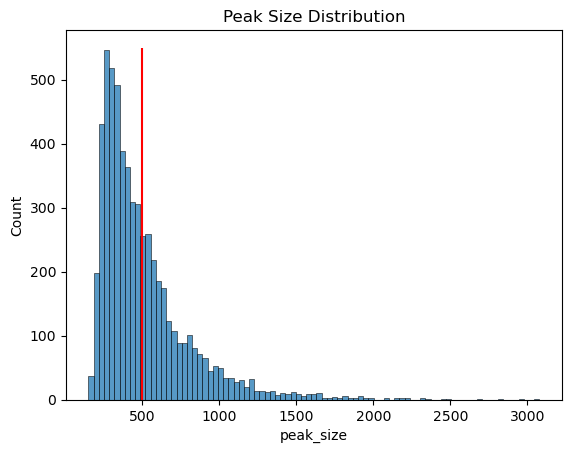

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.histplot(
    data=peaks,
    x='peak_size'
)
plt.vlines(x=500,ymin=0,ymax=550,colors='red')
plt.title('Peak Size Distribution')
plt.show()

# Preprocessing bed files

### Storing peak full paths and prefix names

In [104]:
# Construct lists of file paths and corresponding prefixes
import os

sequence_dir = "./peaks_fasta/"
# sequence_dir = "/Volumes/JOE_LOUIS/peaks.bedgraph/bed_cleaned/sequences"

dataset_files = []
# List all files in directory
for file_name in os.listdir(sequence_dir):

    # helping to store file paths and prefix into final list
    temp = []

    # Full Path to file
    file_path = os.path.join(sequence_dir,file_name)
    
    # Generating the prefix name
    prefix_name = file_name.split('.')[0]

    # storing file paths and prefixes into dataset files
    temp.extend([file_path,prefix_name])
    dataset_files.append(temp)

print(dataset_files)    

[['./peaks_fasta/GSE39271_Kc_GFPi_CLAMP.consensus_peaks.fasta', 'GSE39271_Kc_GFPi_CLAMP'], ['./peaks_fasta/GSE39271_S2_GFPi_CLAMP_IP.consensus_peaks.fasta', 'GSE39271_S2_GFPi_CLAMP_IP'], ['./peaks_fasta/GSE39271_S2_MSL2i_CLAMP_IP.consensus_peaks.fasta', 'GSE39271_S2_MSL2i_CLAMP_IP']]


### Creating a dictionary of chip-seq specific dataframes

In [105]:
import pandas as pd
from Bio import SeqIO

def fasta_to_dataframe(fasta_file_path):
    # Creating an empty DataFrame with columns 'ID' and 'Sequence'
    df = pd.DataFrame(columns=['ID', 'Sequence'])
    
    # Reading sequences from the FASTA file and adding them to the DataFrame
    with open(fasta_file_path, 'r') as fasta_file:
        for record in SeqIO.parse(fasta_file, 'fasta'):
            temp_df = pd.DataFrame({'ID': [record.id], 'Sequence': str(record.seq)})
            df = pd.concat([df,temp_df],ignore_index=True)
    return df


# To store dataset specific peak info
dataset_peak_info = {}

for peak_info in dataset_files:
    # storing peak information
    full_path = peak_info[0]
    prefix_name = peak_info[1]

    # Converting FASTA sequences to DataFrame
    fasta_df = fasta_to_dataframe(full_path)
    fasta_df.insert(0,"Prefix",prefix_name)

    fasta_df_updated = []
    for row in fasta_df.index:
        temp = []
        id = fasta_df.loc[row,"ID"]
        
        # more seq information
        chr,start,stop = id.split(':')[0],int(id.split(':')[1].split('-')[0]),int(id.split(':')[1].split('-')[1])
        seq_length = stop - start
        
        # X-chromosome status
        chrX_status = False
        if chr.startswith("chrX"):
            chrX_status = True
        
        # storing updated information
        temp.extend([fasta_df.loc[row,"Prefix"],chr,start,stop,seq_length,chrX_status,fasta_df.loc[row,"Sequence"]])
        fasta_df_updated.append(temp)

    # storing chip-seq dataset in dictionary
    dataset_peak_info[prefix_name] = pd.DataFrame(fasta_df_updated,columns=["prefix","chr","start","stop","seq_length","chrX_status","full_sequence"])

### Below is a example of the value of each key

In [106]:
# sanity check
dataset_peak_info['GSE39271_S2_GFPi_CLAMP_IP'].head()

,prefix,chr,start,stop,seq_length,chrX_status,full_sequence
0,GSE39271_S2_GFPi_CLAMP_IP,chr2L,5059,6067,1008,False,gcagaacagatatttagattgcctctcattttctctcccatattat...
1,GSE39271_S2_GFPi_CLAMP_IP,chr2L,66704,67126,422,False,AAACTGGTGGAAAGAAAAACCAGCCGACTACATTTACGCCATTGAG...
2,GSE39271_S2_GFPi_CLAMP_IP,chr2L,67185,67461,276,False,TTTCGAGAAAAGAATAAATGGAAAAATACTATTTTCCACAAAAACA...
3,GSE39271_S2_GFPi_CLAMP_IP,chr2L,72043,72838,795,False,GCCAGGATGAAACCTATCAGAGGTTTAAAAATGAGGATGTAAGTTT...
4,GSE39271_S2_GFPi_CLAMP_IP,chr2L,72963,73556,593,False,GAAATGAATTTAAAGTGCGTAATCGGGATACTATAGCGCAAATACT...


In [107]:
dataset_peak_info['GSE39271_Kc_GFPi_CLAMP'].head()

,prefix,chr,start,stop,seq_length,chrX_status,full_sequence
0,GSE39271_Kc_GFPi_CLAMP,chr2L,66719,67472,753,False,AAAACCAGCCGACTACATTTACGCCATTGAGGCCACATGGATAGAG...
1,GSE39271_Kc_GFPi_CLAMP,chr2L,72315,72836,521,False,ATCTCGGGGTTGATAAAAAGTATTGAGCTATAGGTGGCCTCGGTCA...
2,GSE39271_Kc_GFPi_CLAMP,chr2L,72951,73468,517,False,AGGTGGTGGATGGAAATGAATTTAAAGTGCGTAATCGGGATACTAT...
3,GSE39271_Kc_GFPi_CLAMP,chr2L,107829,108346,517,False,AAAACCACAGTGAGTATAAAATAAAGGATCTGGATCTAGATTCACT...
4,GSE39271_Kc_GFPi_CLAMP,chr2L,109098,109448,350,False,ATTTGCACGACTTGAACAGAGGCTGAGAACGGGAAGAAGAGCTAGT...


### Finding center of the peak and collecting 250bp flanking bps

In [108]:
from Bio.Seq import Seq

def extract_center_subsequence(sequence_str, flanking_bp=250):
    # Creating a BioPython sequence object
    sequence = Seq(sequence_str)
    sequence = sequence.upper()
    
    # Finding the center position
    center_index = len(sequence) // 2
    
    # Calculating the start and end indices for the subsequence
    start_index = max(0, center_index - flanking_bp)
    end_index = min(len(sequence), center_index + flanking_bp + 1)
    
    # Extracting the subsequence
    subsequence = sequence[start_index:end_index]
    
    # padding sequences less than 500 bp
    while len(subsequence) < 501:
        subsequence+="N"
    
    return subsequence


for df in dataset_peak_info.keys():

    full_sequence_col = dataset_peak_info[df]['full_sequence']
    
    sub_seq_subsets = pd.DataFrame()
    for full_seq in full_sequence_col:
        
        sub_seq = extract_center_subsequence(full_seq)
        sub_seq_subsets = pd.concat([sub_seq_subsets,pd.DataFrame([str(sub_seq)])],ignore_index=True)
    
    dataset_peak_info[df]['500bp_sequence'] = sub_seq_subsets

### Each key would hold the dataset specific sequences & info for labeling

In [109]:
dataset_peak_info['GSE39271_S2_GFPi_CLAMP_IP'].head()

,prefix,chr,start,stop,seq_length,chrX_status,full_sequence,500bp_sequence
0,GSE39271_S2_GFPi_CLAMP_IP,chr2L,5059,6067,1008,False,gcagaacagatatttagattgcctctcattttctctcccatattat...,AGAGTGGTGCCAACATATTGTGCTCTTCGATTTTTTGGCAACCCAA...
1,GSE39271_S2_GFPi_CLAMP_IP,chr2L,66704,67126,422,False,AAACTGGTGGAAAGAAAAACCAGCCGACTACATTTACGCCATTGAG...,AAACTGGTGGAAAGAAAAACCAGCCGACTACATTTACGCCATTGAG...
2,GSE39271_S2_GFPi_CLAMP_IP,chr2L,67185,67461,276,False,TTTCGAGAAAAGAATAAATGGAAAAATACTATTTTCCACAAAAACA...,TTTCGAGAAAAGAATAAATGGAAAAATACTATTTTCCACAAAAACA...
3,GSE39271_S2_GFPi_CLAMP_IP,chr2L,72043,72838,795,False,GCCAGGATGAAACCTATCAGAGGTTTAAAAATGAGGATGTAAGTTT...,ATATGAATGAAGAATATACATACTAGAAAAGTTTCTTAATGTAGAT...
4,GSE39271_S2_GFPi_CLAMP_IP,chr2L,72963,73556,593,False,GAAATGAATTTAAAGTGCGTAATCGGGATACTATAGCGCAAATACT...,GAGTGGTTTAGTGATAGTGCTTAAAGTGTAAACATGTGTTTGTACG...


In [110]:
dataset_peak_info['GSE39271_Kc_GFPi_CLAMP'].head()

,prefix,chr,start,stop,seq_length,chrX_status,full_sequence,500bp_sequence
0,GSE39271_Kc_GFPi_CLAMP,chr2L,66719,67472,753,False,AAAACCAGCCGACTACATTTACGCCATTGAGGCCACATGGATAGAG...,AAAGTCGTGTAAGTGTTTAATACAAGCAACAGTCAGGGAGCACGCA...
1,GSE39271_Kc_GFPi_CLAMP,chr2L,72315,72836,521,False,ATCTCGGGGTTGATAAAAAGTATTGAGCTATAGGTGGCCTCGGTCA...,TGATAAAAAGTATTGAGCTATAGGTGGCCTCGGTCAGGCCGGCATA...
2,GSE39271_Kc_GFPi_CLAMP,chr2L,72951,73468,517,False,AGGTGGTGGATGGAAATGAATTTAAAGTGCGTAATCGGGATACTAT...,GATGGAAATGAATTTAAAGTGCGTAATCGGGATACTATAGCGCAAA...
3,GSE39271_Kc_GFPi_CLAMP,chr2L,107829,108346,517,False,AAAACCACAGTGAGTATAAAATAAAGGATCTGGATCTAGATTCACT...,AGTGAGTATAAAATAAAGGATCTGGATCTAGATTCACTACAGTTCA...
4,GSE39271_Kc_GFPi_CLAMP,chr2L,109098,109448,350,False,ATTTGCACGACTTGAACAGAGGCTGAGAACGGGAAGAAGAGCTAGT...,ATTTGCACGACTTGAACAGAGGCTGAGAACGGGAAGAAGAGCTAGT...


### Generating Kmers & Relevant Dictionary

In [120]:
import numpy as np

def generate_kmers(sequence, k):
    """
    Function to generate k-mers from a sequence.
    """
    kmers = [str(sequence[i:i+k]) for i in range(len(sequence) - k + 1)]
    return kmers

kmer_dict = {}
for key in dataset_peak_info.keys():
    df = dataset_peak_info[key]

    kmer_temp_list = []
    for i in df.index:
        seq = df.loc[i,'500bp_sequence']
        kmers = generate_kmers(seq,6) # kmer size here
        kmer_temp_list.append(kmers)
    
    kmer_arr = kmer_temp_list
    # kmer_arr = np.array(kmer_temp_list)

    kmer_dict[key] = kmer_arr

In [97]:
kmer_dict['GSE39271_S2_GFPi_CLAMP_IP'][0][0:5]

['AGAGTG', 'GAGTGG', 'AGTGGT', 'GTGGTG', 'TGGTGC']

In [113]:
kmer_dict['GSE39271_Kc_GFPi_CLAMP'][0][0:5]

['AAAGTC', 'AAGTCG', 'AGTCGT', 'GTCGTG', 'TCGTGT']

In [114]:
# obtaining keys to use in dictionary =
import numpy as np

def get_unique_items(kmer_list):
    unique_items = set()
    for item in kmer_list:
        if isinstance(item, list):
            unique_items.update(get_unique_items(item))
        else:
            unique_items.add(item)
    return unique_items

all_keys = get_unique_items(kmer_dict['GSE39271_S2_GFPi_CLAMP_IP']) # choose chip-seq dataset to process
print(all_keys)

{'AAATCT', 'TATCCA', 'GTTGAA', 'CTAGTN', 'TGGANN', 'TTCCGT', 'GAGGCA', 'CGCCGA', 'CGCCAN', 'TACCTT', 'TATGAN', 'ATAAGC', 'CGTAGC', 'AGAAGG', 'TNNNNN', 'CGTAAA', 'TTGCGT', 'TAATAG', 'TACACG', 'GAACNN', 'ATGGCG', 'CTCTGG', 'CACTCG', 'GCCGAG', 'AAGGTT', 'CTAGAN', 'AATGCN', 'CATGNN', 'TTCACT', 'GCGGCT', 'TACTTT', 'TCAGCT', 'GCNNNN', 'TGCGGA', 'TCTCAA', 'CGGGCC', 'ACAATT', 'GGTGCN', 'TTTTGA', 'GTGAGT', 'GGGCAG', 'GCGAAG', 'CTTCGC', 'ATGTGA', 'GACTTA', 'GTCAGA', 'CGAGCA', 'ACAATN', 'CCCCCG', 'CCGGCC', 'ACGTAT', 'TTCATN', 'CGGATA', 'CAACCG', 'CCTGAA', 'AGATAA', 'GTGACA', 'TTCGCG', 'TCGGNN', 'AAATAG', 'GCACGC', 'ATGTTG', 'CAAGNN', 'TCTATG', 'GGTCNN', 'GCAACA', 'GTCGNN', 'TGGCAA', 'CTTGGG', 'CCTATC', 'TCGGGG', 'TAATTT', 'TAGAAA', 'TGGATG', 'GCCTTN', 'CTATAT', 'TAATCN', 'ATCACC', 'ATCAAA', 'CTGACT', 'GTTGAN', 'ACCAAT', 'AGCCAN', 'TCGAGG', 'CTATTC', 'GATTTN', 'GGTCCA', 'TTGGGC', 'TGTCGN', 'CTCGCC', 'ATCACG', 'AGGCGN', 'GCTTAG', 'GCCTNN', 'GATNNN', 'GTCNNN', 'CCATGN', 'GTCGAG', 'CCTCAT', 'TTGGGA',

In [115]:
# constructing dictionary
dna_dict = {}
counter = 0 
for i in all_keys:
    dna_dict[i] = counter
    counter+=1

print("Number of Items in Dictionary:",len(dna_dict))

Number of Items in Dictionary: 5367


In [116]:
# replacing keys with values in the dataset
print("Original Sequence:",kmer_dict['GSE39271_S2_GFPi_CLAMP_IP'][0][0:5])

def replace_values(kmer_list, kmer_dict):
    """
    Given a nested list, replaces every item with the corresponding value in a dictionary.
    """
    if isinstance(kmer_list, list):
        return [replace_values(item, kmer_dict) for item in kmer_list]
    elif kmer_list in kmer_dict:
        return kmer_dict[kmer_list]
    else:
        return kmer_list

seqs_out = replace_values(kmer_dict['GSE39271_S2_GFPi_CLAMP_IP'],dna_dict)
print("Updated Sequence:",seqs_out[0][0:5])

Original Sequence: ['AGAGTG', 'GAGTGG', 'AGTGGT', 'GTGGTG', 'TGGTGC']
Updated Sequence: [1014, 3346, 1775, 3234, 4927]


# Dicitonaries with all info

In [118]:
kmer_dict.keys()

dict_keys(['GSE39271_Kc_GFPi_CLAMP', 'GSE39271_S2_GFPi_CLAMP_IP', 'GSE39271_S2_MSL2i_CLAMP_IP'])

In [123]:
kmer_dict['GSE39271_Kc_GFPi_CLAMP'][0][0:5] 

['AAAGTC', 'AAGTCG', 'AGTCGT', 'GTCGTG', 'TCGTGT']

In [119]:
dataset_peak_info.keys()

dict_keys(['GSE39271_Kc_GFPi_CLAMP', 'GSE39271_S2_GFPi_CLAMP_IP', 'GSE39271_S2_MSL2i_CLAMP_IP'])

In [121]:
dataset_peak_info['GSE39271_Kc_GFPi_CLAMP'].head()

,prefix,chr,start,stop,seq_length,chrX_status,full_sequence,500bp_sequence
0,GSE39271_Kc_GFPi_CLAMP,chr2L,66719,67472,753,False,AAAACCAGCCGACTACATTTACGCCATTGAGGCCACATGGATAGAG...,AAAGTCGTGTAAGTGTTTAATACAAGCAACAGTCAGGGAGCACGCA...
1,GSE39271_Kc_GFPi_CLAMP,chr2L,72315,72836,521,False,ATCTCGGGGTTGATAAAAAGTATTGAGCTATAGGTGGCCTCGGTCA...,TGATAAAAAGTATTGAGCTATAGGTGGCCTCGGTCAGGCCGGCATA...
2,GSE39271_Kc_GFPi_CLAMP,chr2L,72951,73468,517,False,AGGTGGTGGATGGAAATGAATTTAAAGTGCGTAATCGGGATACTAT...,GATGGAAATGAATTTAAAGTGCGTAATCGGGATACTATAGCGCAAA...
3,GSE39271_Kc_GFPi_CLAMP,chr2L,107829,108346,517,False,AAAACCACAGTGAGTATAAAATAAAGGATCTGGATCTAGATTCACT...,AGTGAGTATAAAATAAAGGATCTGGATCTAGATTCACTACAGTTCA...
4,GSE39271_Kc_GFPi_CLAMP,chr2L,109098,109448,350,False,ATTTGCACGACTTGAACAGAGGCTGAGAACGGGAAGAAGAGCTAGT...,ATTTGCACGACTTGAACAGAGGCTGAGAACGGGAAGAAGAGCTAGT...
